# Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import math
import missingno as msno
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# configuration
RANDOM_STATE = 196
TRIAL = 25 # for hyperparameter tuning

import warnings
warnings.filterwarnings("ignore")

# 1. Load Dataset

In [3]:
df = pd.read_csv('/kaggle/input/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

# 2. Exploratory Data Analysis (EDA)

In [4]:
df.shape

(426880, 26)

In [5]:
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [6]:
unique_counts = df.nunique().sort_values(ascending=False)
print(unique_counts)

id              426880
url             426880
posting_date    381536
description     360911
image_url       241899
VIN             118264
odometer        104870
long             53772
lat              53181
model            29667
price            15655
region_url         413
region             404
year               114
state               51
manufacturer        42
type                13
paint_color         12
cylinders            8
title_status         6
condition            6
fuel                 5
size                 4
drive                3
transmission         3
county               0
dtype: int64


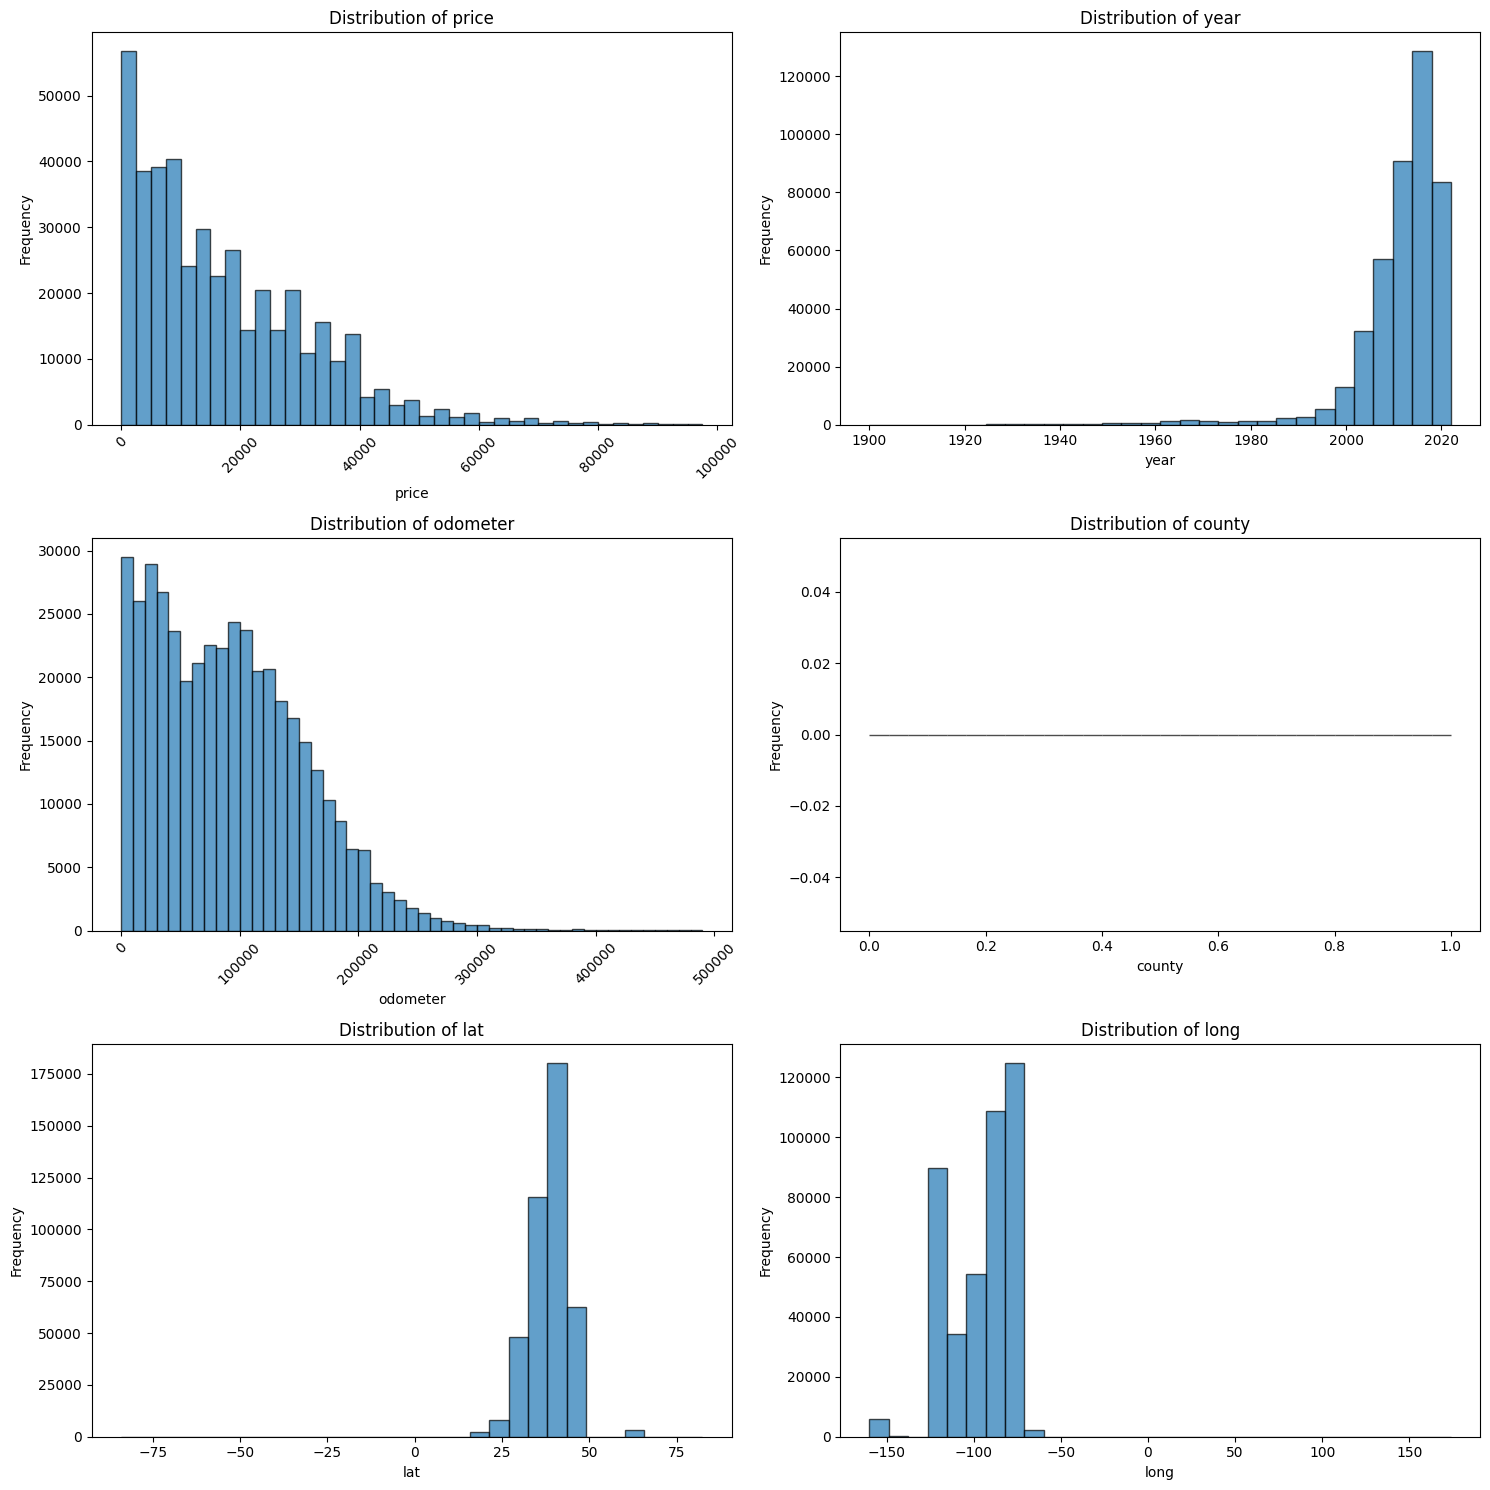

In [7]:
plt.figure(figsize=(15, 15))

numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop(['id'])

large_range_cols = ['price', 'odometer']  

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    if col.lower() in [c.lower() for c in large_range_cols]:
        data = df[col].dropna()
        
        if 'price' in col.lower():
            bins = range(0, 100000, 2500)  
            
        elif 'odometer' in col.lower():
            bins = range(0, 500000, 10000)
        
        plt.title(f'Distribution of {col}')
        plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')
        plt.xlabel(col)
        
        plt.xticks(rotation=45)

    else:
        plt.hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
    
    plt.ylabel('Frequency')
    # plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

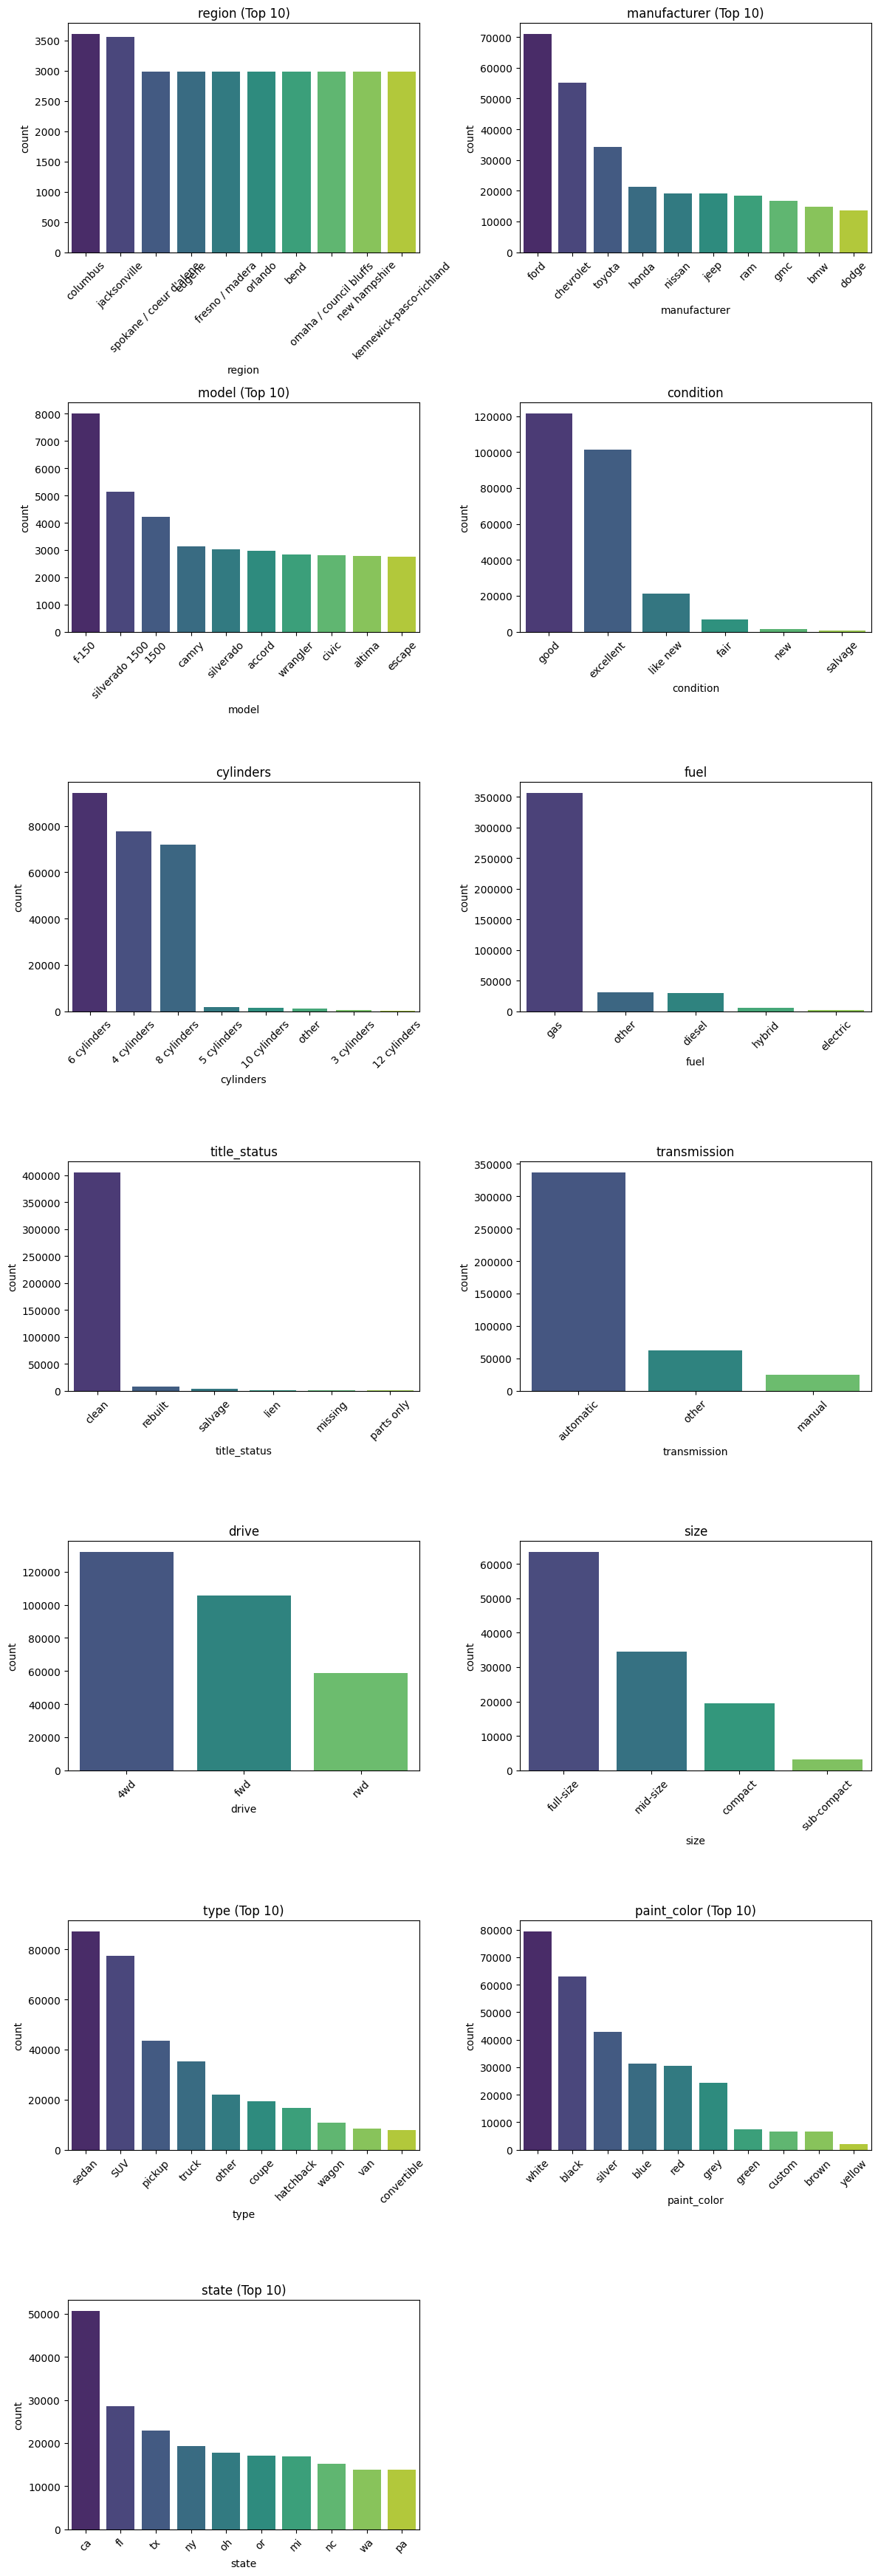

In [8]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop(['url', 'region_url', 'image_url', 'VIN', 'posting_date', 'description'])

n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5), dpi=100)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    unique_vals = df[col].nunique()

    if unique_vals > 10:
        top10 = df[col].value_counts().nlargest(10).index
        filtered_df = df[df[col].isin(top10)]
        sns.countplot(x=col, data=filtered_df, order=top10, palette='viridis', ax=ax)
        ax.set_title(f'{col} (Top 10)')
    else:
        sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette='viridis', ax=ax)
        ax.set_title(col)

    ax.tick_params(axis='x', rotation=45)

for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
corr = df.corr(numeric_only=True)

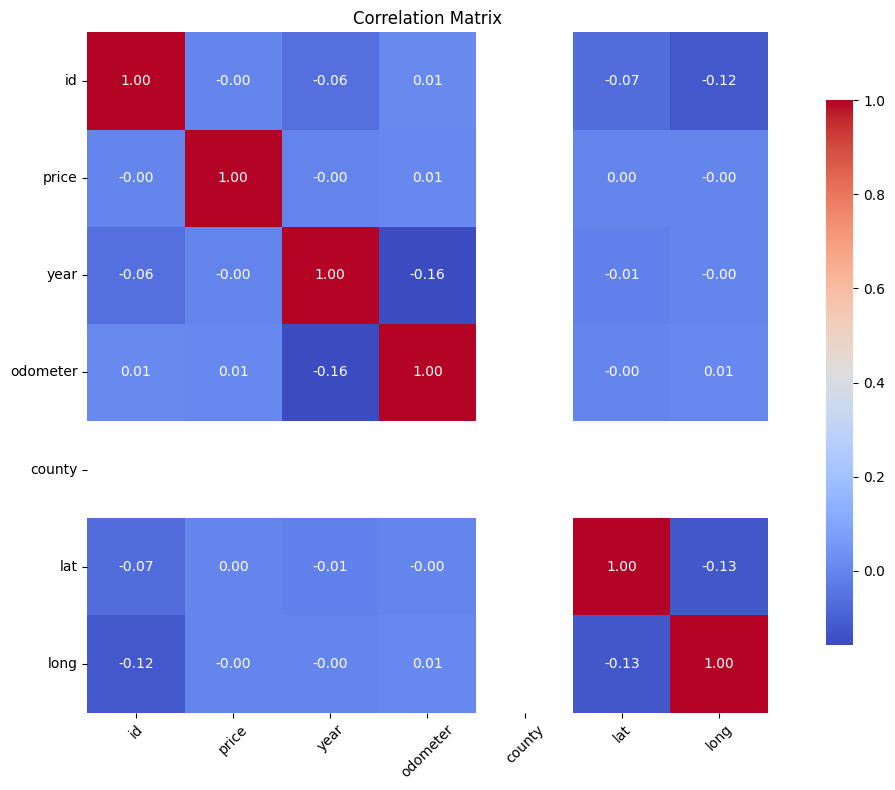

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

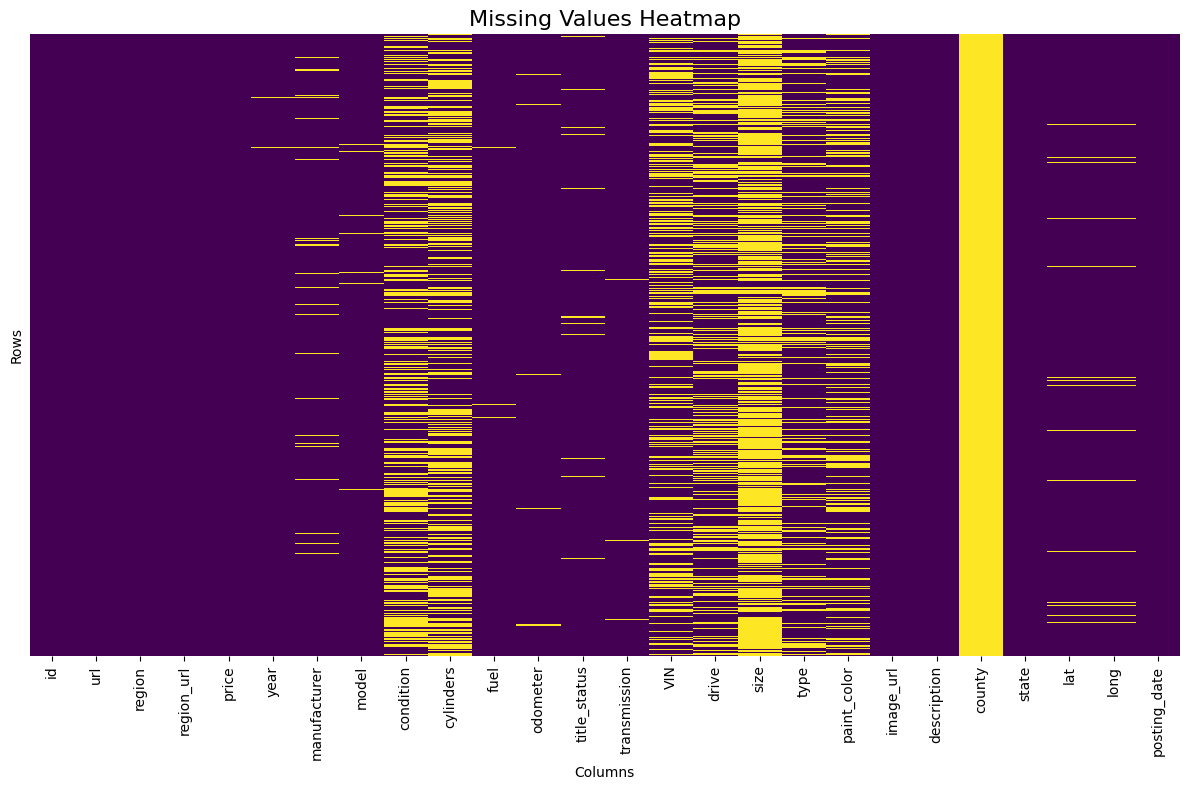

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap", fontsize=16)
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [12]:
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

missing_counts_sorted = missing_counts.sort_values(ascending=False)

missing_percentage = (missing_counts_sorted / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Count': missing_counts_sorted,
    'Missing %': missing_percentage.round(2)
})

print(missing_info)

              Missing Count  Missing %
county               426880     100.00
size                 306361      71.77
cylinders            177678      41.62
condition            174104      40.79
VIN                  161042      37.73
drive                130567      30.59
paint_color          130203      30.50
type                  92858      21.75
manufacturer          17646       4.13
title_status           8242       1.93
long                   6549       1.53
lat                    6549       1.53
model                  5277       1.24
odometer               4400       1.03
fuel                   3013       0.71
transmission           2556       0.60
year                   1205       0.28
description              70       0.02
image_url                68       0.02
posting_date             68       0.02


# 3. Drop Irrelevant Columns

In [13]:
# drop unused columns
col_drop = ['county', 'size', 'id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'lat', 'long']
df.drop(columns=col_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  state         426880 non-null  object 
 15  posting_date  426812 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 52.1+ MB


# 4. Handling Missing Values

In [14]:
df.isna().sum().sort_values(ascending=False)

cylinders       177678
condition       174104
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
posting_date        68
region               0
price                0
state                0
dtype: int64

In [15]:
# drop row that have null in posting_date data
df = df.dropna(subset=['posting_date'])

# drop row that have null in numeric cols 
df = df.dropna(subset=df.select_dtypes(include='number').columns)

# impute cat cols with Unknown
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [16]:
# check for any missing values
df.isna().sum().sort_values(ascending=False)

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
posting_date    0
dtype: int64

# 5. Drop Duplicate Data

In [17]:
# drop duplicate
df.drop_duplicates(inplace=True)
df.shape

(421316, 16)

# 6. Handling Outliers

In [18]:
df['year'] = df['year'].astype(int)
df['odometer'] = df['odometer'].astype(int)

numeric_cols = df.select_dtypes(include=['number']).columns

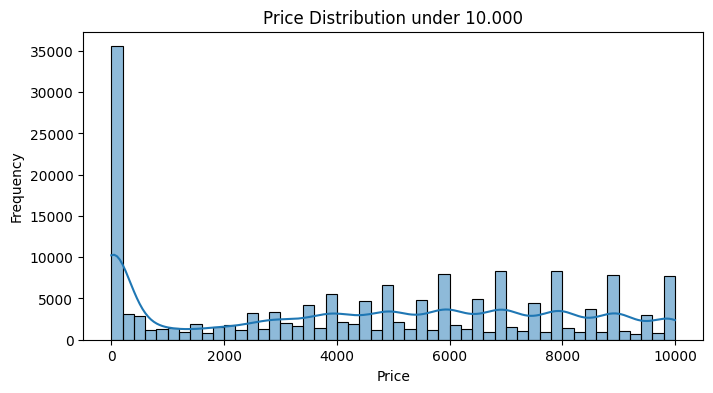

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(df[df['price'] < 10000]['price'], bins=50, kde=True)
plt.title('Price Distribution under 10.000')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [20]:
# drop data with price under 2000
# df = df[df['price'] >= 2000]

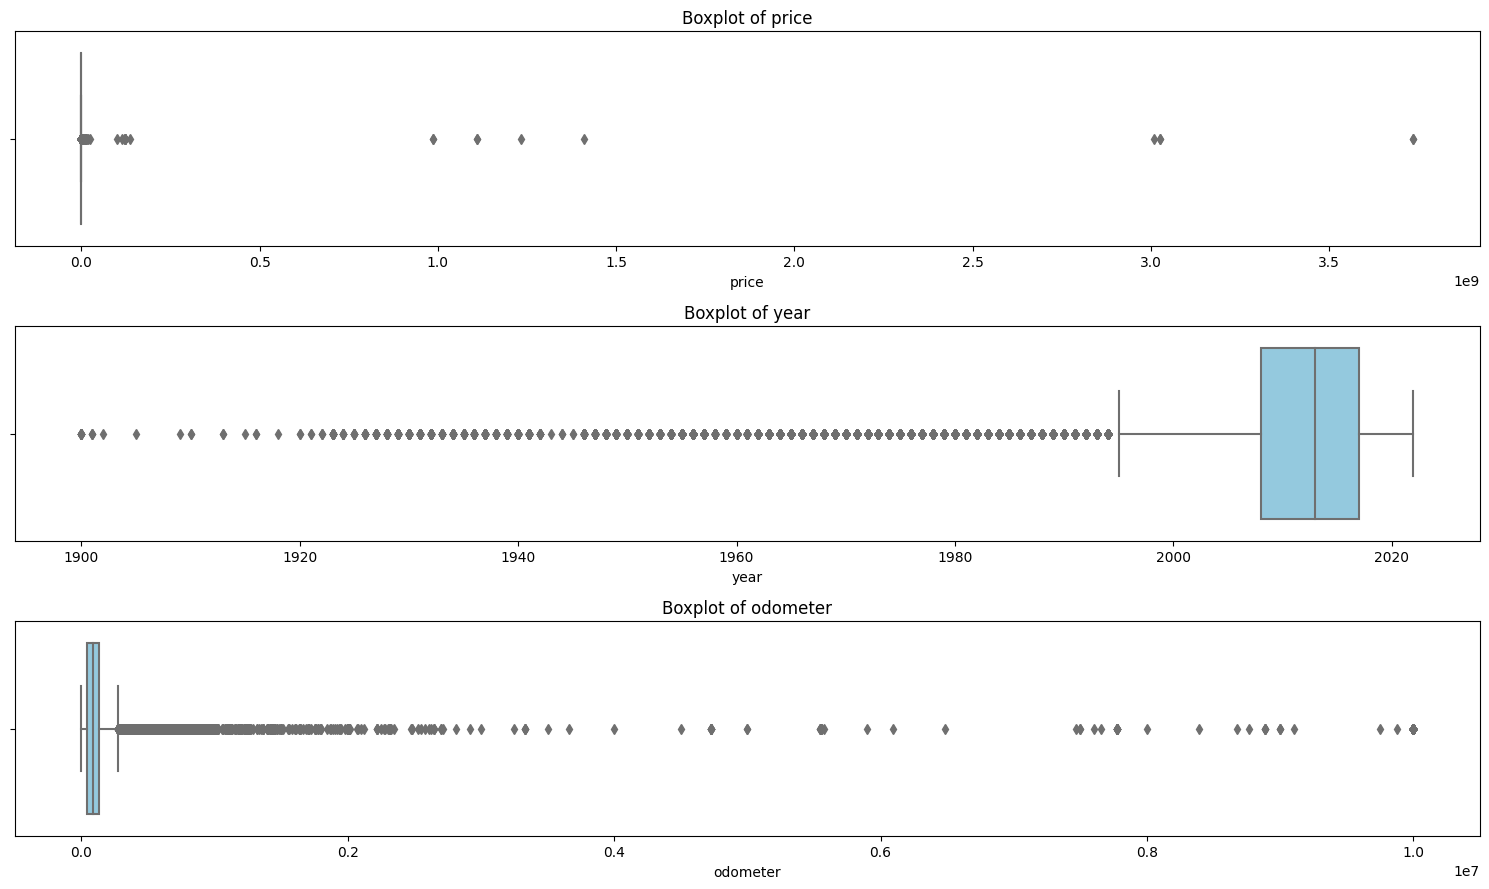

In [21]:
# check for outliers
plt.figure(figsize=(15, len(numeric_cols)*3))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    
plt.show()

In [22]:
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

for col, count in outlier_counts.items():
    print(f"{col}: {count} outlier")

price: 7921 outlier
year: 15857 outlier
odometer: 4354 outlier


In [23]:
# handling outliers
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

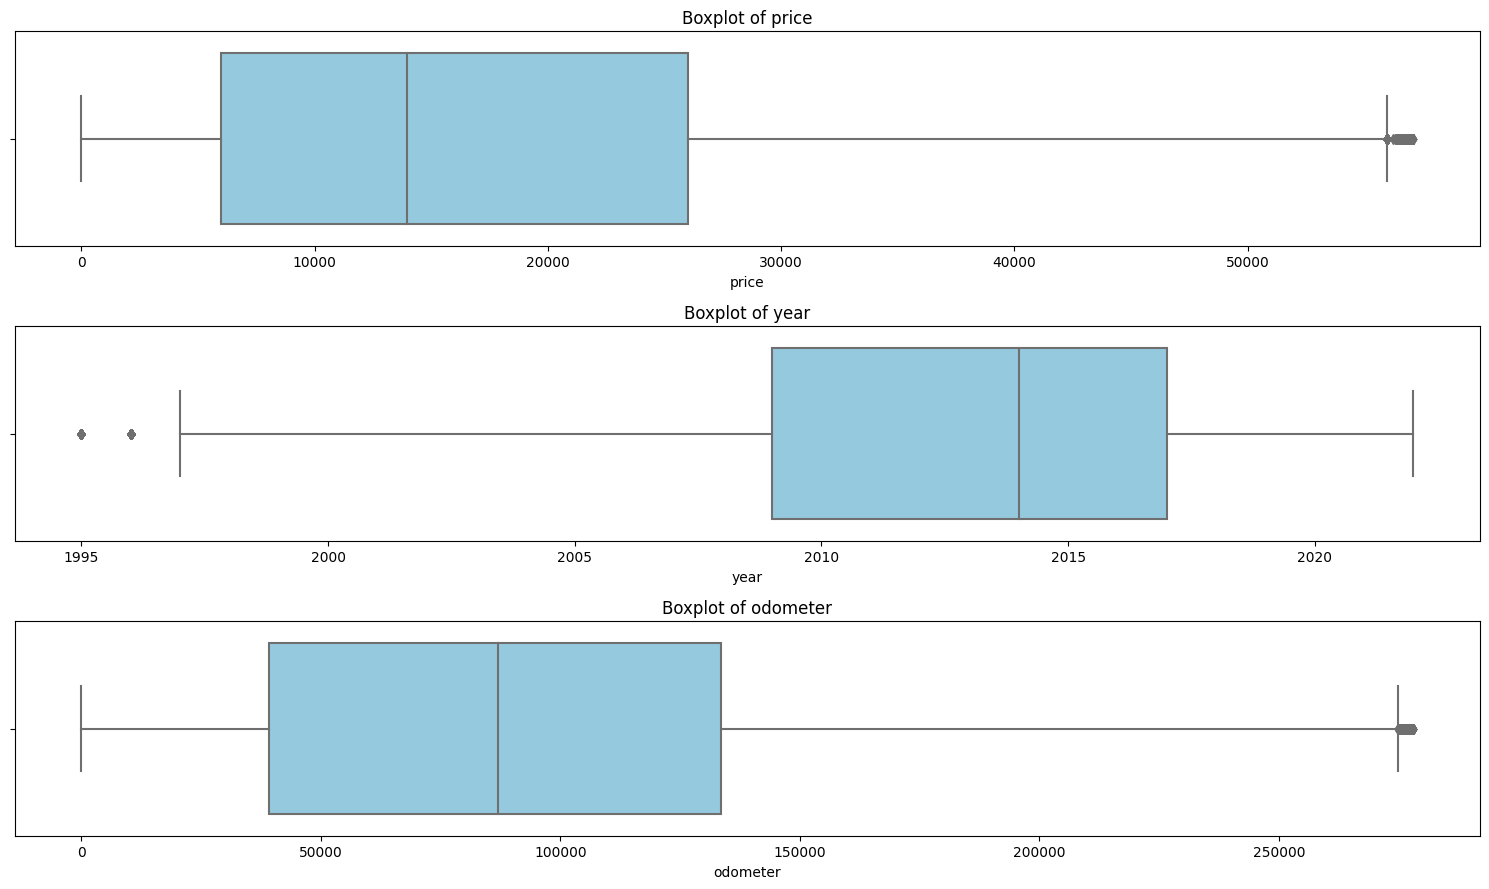

In [24]:
# check for outliers
plt.figure(figsize=(15, len(numeric_cols)*3))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    
plt.show()

# 7. Feature Engineering

In [25]:
# change cylinders to numeric
def map_cylinders(val):
    if val == 'other' or val == 'Unknown':
        return 0
    else: 
        return int(val.split()[0])

df['cylinders'] = df['cylinders'].apply(map_cylinders)

In [26]:
# calculate car age at the time of posting
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce', utc=True)
df['posting_year'] = df['posting_date'].dt.year
df['car_age'] = df['posting_year'] - df['year']

df.drop(columns=['year', 'posting_year', 'posting_date'], inplace=True)
df = df[df['car_age'] >= 0]
df = df[df['car_age'].notna()]

df['is_old_car'] = (df['car_age'] > 10).astype(int)

In [27]:
df['odometer_per_year'] = df['odometer'] / (df['car_age'] + 1)

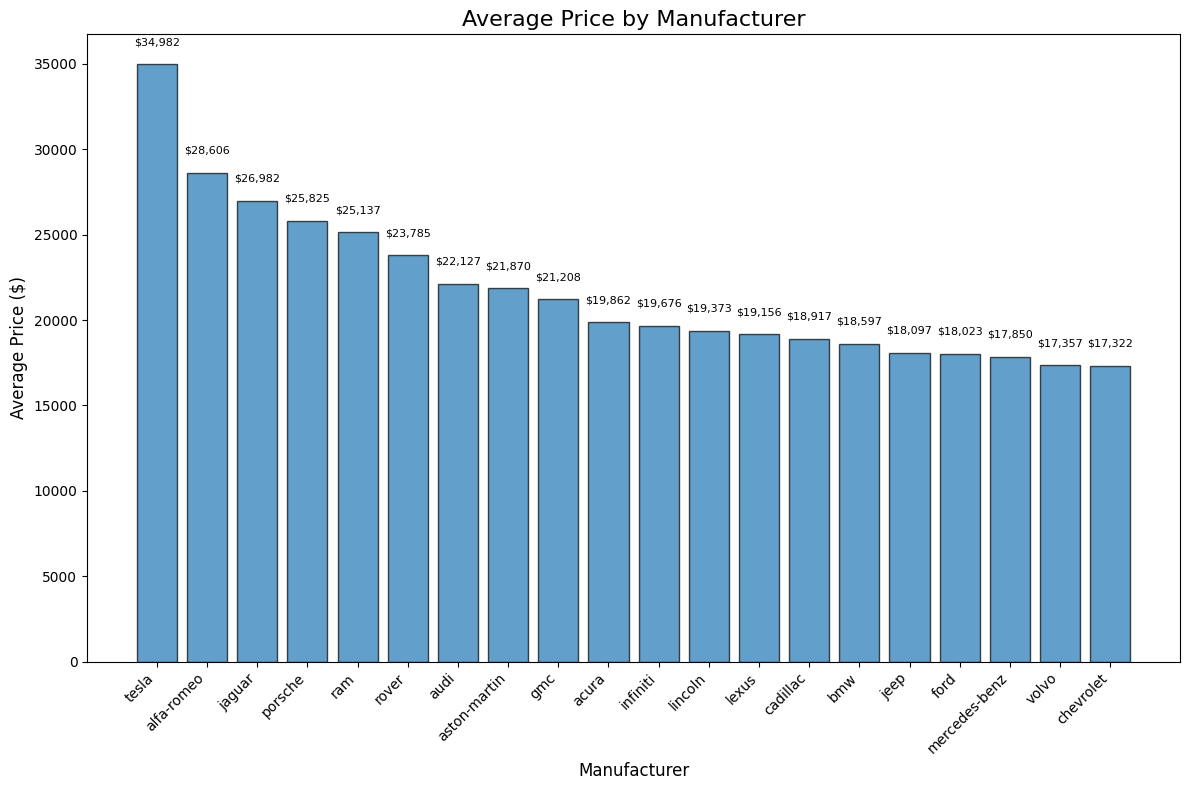

In [28]:
manufacturer_price_mean = df.groupby('manufacturer')['price'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(manufacturer_price_mean)), manufacturer_price_mean.values, 
               alpha=0.7, edgecolor='black')

plt.title('Average Price by Manufacturer', fontsize=16)
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks(range(len(manufacturer_price_mean)), manufacturer_price_mean.index, 
           rotation=45, ha='right')

plt.ticklabel_format(style='plain', axis='y')

for i, v in enumerate(manufacturer_price_mean.values):
    plt.text(i, v + 1000, f'${v:,.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [29]:
top_brands = manufacturer_price_mean.head(5).index.tolist()
top_brands

df['is_top_brand'] = df['manufacturer'].isin(top_brands).astype(int)

In [30]:
df.head()

,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_age,is_old_car,odometer_per_year,is_top_brand
27,auburn,33590,gmc,sierra 1500 crew cab slt,good,8,gas,57923,clean,other,Unknown,pickup,white,al,7,0,7240.375000,0
28,auburn,22590,chevrolet,silverado 1500,good,8,gas,71229,clean,other,Unknown,pickup,blue,al,11,1,5935.750000,0
29,auburn,39590,chevrolet,silverado 1500 crew,good,8,gas,19160,clean,other,Unknown,pickup,red,al,1,0,9580.000000,0
30,auburn,30990,toyota,tundra double cab sr,good,8,gas,41124,clean,other,Unknown,pickup,red,al,4,0,8224.800000,0
31,auburn,15000,ford,f-150 xlt,excellent,6,gas,128000,clean,automatic,rwd,truck,black,al,8,0,14222.222222,0


In [31]:
# use ordinal encoding for condition
condition_order = {
    'Unknown': 0,
    'salvage': 1,
    'fair': 2, 
    'good': 3, 
    'excellent': 4,
    'like new': 5, 
    'new': 6 
}

df['condition_encoded'] = df['condition'].map(condition_order)
df.drop(columns=['condition'], inplace=True)

# 8. Data Preparation & Training 

In [32]:
X = df.drop(columns=['price'])
y = df['price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [34]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

def build_pipeline(model):
    preprocessor = ColumnTransformer([
        ('cat', TargetEncoder(), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])
    
    return Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])

In [35]:
def evaluate_model(name, model, X_test, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name}:\nRMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}\n")

    return {
        'Model': name,
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

In [36]:
models = {
    'Linear Regression': LinearRegression(),
    # 'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    # 'ElasticNet': ElasticNet(random_state=RANDOM_STATE),
    # 'SGD Regressor': SGDRegressor(random_state=RANDOM_STATE, max_iter=1000, tol=1e-3),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1, random_state=RANDOM_STATE),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost Regressor': XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
    # 'LightGBM Regressor': LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1),
    'CatBoost Regressor': CatBoostRegressor(random_seed=RANDOM_STATE, verbose=0),
    'MLP Regressor': MLPRegressor(
        hidden_layer_sizes=(32, 32),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate_init=0.01,
        max_iter=500,
        early_stopping=True,
        random_state=RANDOM_STATE
    ),
}

In [37]:
results = []

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    pipeline = build_pipeline(model)
    
    neg_mse_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    eval_result = evaluate_model(name, model, X_test, y_test, y_pred)

    results.append({
        'Model': name,
        'CV RMSE Mean': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test RMSE': eval_result['RMSE'],
        'Test MSE': eval_result['MSE'],
        'Test MAE': eval_result['MAE'],
        'Test R2': eval_result['R2']
    })

results_df = pd.DataFrame(results).sort_values(by='CV RMSE Mean').reset_index(drop=True)
print(results_df)

Linear Regression:
RMSE: 8635.51, MSE: 74572011.72, MAE: 5937.37, R²: 0.5694

Lasso:
RMSE: 8635.48, MSE: 74571527.78, MAE: 5937.36, R²: 0.5694

Decision Tree Regressor:
RMSE: 7497.73, MSE: 56215943.78, MAE: 3245.91, R²: 0.6754

Random Forest Regressor:
RMSE: 7648.13, MSE: 58493936.75, MAE: 4887.24, R²: 0.6622

XGBoost Regressor:
RMSE: 6710.91, MSE: 45036318.92, MAE: 4208.69, R²: 0.7399

CatBoost Regressor:
RMSE: 6664.54, MSE: 44416128.10, MAE: 4147.88, R²: 0.7435

MLP Regressor:
RMSE: 8221.86, MSE: 67598948.98, MAE: 5424.25, R²: 0.6096

                     Model  CV RMSE Mean  CV RMSE Std    Test RMSE  \
0       CatBoost Regressor   6735.940993    20.415349  6664.542602   
1        XGBoost Regressor   6778.833944    52.311744  6710.910439   
2  Random Forest Regressor   7712.615626    51.437635  7648.132893   
3  Decision Tree Regressor   7838.256033    90.112451  7497.729242   
4            MLP Regressor   8424.533456    59.789892  8221.858000   
5        Linear Regression   8738.278

# 9. Hyperparameter Tuning

In [ ]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

In [ ]:
def objective_lasso(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
        'random_state': RANDOM_STATE,
        'max_iter': 10000
    }
    model = Lasso(**params)
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=cv, n_jobs=-1)
    return -scores.mean()

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': RANDOM_STATE,
        'verbose': 0
    }
    model = CatBoostRegressor(**params)
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=cv, n_jobs=-1)
    return -scores.mean()

def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': RANDOM_STATE,
        'verbosity': 0
    }
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=cv, n_jobs=-1)
    return -scores.mean()

def objective_decision_tree(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': RANDOM_STATE
    }
    model = DecisionTreeRegressor(**params)
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=cv, n_jobs=-1)
    return -scores.mean()

def objective_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': RANDOM_STATE
    }
    model = RandomForestRegressor(**params)
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=cv, n_jobs=-1)
    return -scores.mean()

In [ ]:
best_model_name = results_df.iloc[0]['Model']
print(f"Model terbaik untuk dituning berdasarkan CV RMSE Mean: {best_model_name}")

best_model = None

In [ ]:
if best_model_name == 'CatBoost Regressor':
    study_catboost = optuna.create_study(direction='minimize')
    study_catboost.optimize(objective_catboost, n_trials=TRIAL)
    print("Best CatBoost params:", study_catboost.best_params)
    print("Best CatBoost score:", study_catboost.best_value)
    best_model = CatBoostRegressor(**study_catboost.best_params, verbose=0)

elif best_model_name == 'XGBoost Regressor':
    study_xgboost = optuna.create_study(direction='minimize')
    study_xgboost.optimize(objective_xgboost, n_trials=TRIAL)
    print("Best XGBoost params:", study_xgboost.best_params)
    print("Best XGBoost score:", study_xgboost.best_value)
    best_model = XGBRegressor(**study_xgboost.best_params)

elif best_model_name == 'Random Forest Regressor':
    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_random_forest, n_trials=TRIAL)
    print("Best Random Forest params:", study_rf.best_params)
    print("Best Random Forest score:", study_rf.best_value)
    best_model = RandomForestRegressor(**study_rf.best_params)

elif best_model_name == 'Decision Tree Regressor':
    study_dt = optuna.create_study(direction='minimize')
    study_dt.optimize(objective_decision_tree, n_trials=TRIAL)
    print("Best Decision Tree params:", study_dt.best_params)
    print("Best Decision Tree score:", study_dt.best_value)
    best_model = DecisionTreeRegressor(**study_dt.best_params)

elif best_model_name == 'Lasso':
    study_lasso = optuna.create_study(direction='minimize')
    study_lasso.optimize(objective_lasso, n_trials=TRIAL)
    print("Best Lasso params:", study_lasso.best_params)
    print("Best Lasso score:", study_lasso.best_value)
    best_model = Lasso(**study_lasso.best_params)

else:
    print(f"Tuning for the model '{best_model_name}' is not yet implemented. Using default...")
    best_model = models[best_model_name]

# 10. Result

In [ ]:
pipeline = build_pipeline(models['XGBoost Regressor'])
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)

result = evaluate_model('Test', pipeline, X_test, y_test, y_test_pred)

y_train_pred = pipeline.predict(X_train)
train_result = evaluate_model('Train', pipeline, X_train, y_train, y_train_pred)

In [ ]:
plt.figure(figsize=(8, 6))
plt.hexbin(y_test, y_test_pred, gridsize=50, cmap='Blues', bins='log')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values: {best_model_name}')
plt.colorbar(label='log(count)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
errors = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, bins=30)
plt.title(f'Distribusi Error: {best_model_name}')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Recursive Feature Elimination

In [ ]:
best_model = models[best_model_name]

if best_model_name != 'MLP Regressor':
    rfe = RFE(estimator=best_model, n_features_to_select=10)
    rfe.fit(X_train, y_train)

    selected_features = X_train.columns[rfe.support_]

    print("\nTop Selected Features by RFE:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i}. {feature}")
else:
    print("RFE is not supported for MLP Regressor.")